In [23]:
%pylab inline
import os
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import keras
from keras.layers import convolutional, Dense, Activation,pooling
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.models import Sequential, Model
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2
from keras import backend as K
from keras.utils import np_utils
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import cPickle as pickle
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import h5py


config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 1.0
set_session(tf.Session(config=config))


Populating the interactive namespace from numpy and matplotlib


In [24]:
###################################### LOADING DATA ##############################

#USER INTERFACE 

### Create a dictionary that contains all the dictiories within each dataset (.mat file) (workspace) we want to load ###
#SELECT data directory
dataDir = input("Enter data directory path: ")  #dataDir = "/scratch/barbieri/DATA_CNN_networks/Data/"
# "/scratch/barbieri/DATA_CNN_networks/data_pickle/"


#Load data
Load_Data = {}  
for i in range(0, len(os.listdir( dataDir ))):  
    Load_Data[i] = {}  #Dictionary for a single workspace


Enter data directory path: "/scratch/barbieri/DATA_CNN_networks/Data/"


In [25]:
def CNN_parameters():
    # Please edit parameters
    
    ## =========================================================================
    # Parameters for the CNN
    
    # Define dictionary for the parameters
    PARAMETERS = {}
    
    # Number of classes
    PARAMETERS['n_classes'] = 6  #3 or 6
    
    # Choose Dropout value
    PARAMETERS['dropout'] = 0.5
    
    # Define number of epochs
    PARAMETERS['n_epoch'] = 200
         
    # Define batch size
    PARAMETERS['batch_size'] = 20
            
    # Define decay value to be tested: write in array format
    PARAMETERS['decay_value'] = [0.001]
    
    # Define the number of iteration per CNN
    PARAMETERS['n_iteration'] = 5
            
    ## =========================================================================
    # Parameters for the data
            
    # Choose the number of curves to use as training data
    PARAMETERS['n_training_data'] = 800

    # Choose number of point to downsample an intensity curve
    PARAMETERS['points_curve'] = 256
    
    return PARAMETERS

In [26]:
def data_dict(Load_Data):
    
    #### Define another dictionary for storing intensity curves and classes ### 
    #From each dataset, the intensity curve and classes are extracted and stored in another dictionary
    DATA = {}
    N_of_file =len(os.listdir( dataDir ))
    for i in range(0, N_of_file):
            DATA[i] = {}

    
    #Find the minimun length among all the intensity curves
    Int_curve_lengths = np.zeros(N_of_file)
    for i in range(0, N_of_file):
        Int_curve_lengths [i] = (len(Load_Data[i]['RAWDATA'][0,0]['files'][0,0][0]['intensity'][0][0]))
    Int_curve_len = (min(Int_curve_lengths.astype(int)))


    #### Fill the dictionary ###
    Ncell_classified = 200 #Number of classified cells per dataset
    for i in range(0, N_of_file):
        #Decision array for each dataset
        DATA[i]['decision'] = Load_Data[i]['decisionlist']   
        #Size of the matrix to store intensity values
        NumofData = len(Load_Data[i]['RAWDATA'][0,0]['files'][0,0][0]['intensity'])
        #Empty matrix to store all the intensity values of all the cells
        DATA[i]['intensity'] = np.zeros((Ncell_classified, Int_curve_len))    
        for k in range(0, Ncell_classified): #Only the first 200 were classified
            DATA[i]['intensity'][k,:] = Load_Data[i]['RAWDATA'][0,0]['files'][0,0][0]['intensity'][k][0,0:900] #copy the first 900 values


    ### Classes array: contain values from all the data ###
    Classes=[]
    for i in range( 0, N_of_file ):
        Classes = np.append(Classes , DATA[i]['decision']).astype(int)


    ### Create matrix to store intensity values coming from all the data ###    
    NTot_Data = N_of_file*Ncell_classified
    Intensity = np.zeros((0, DATA[0]['intensity'].shape[1]))
    for i in range( 0, N_of_file ):
        Intensity = np.append(Intensity, DATA[i]['intensity'][:,:], axis=0)    

    
    print(' TEST classes shape data_dict', Classes.shape)
    
    
    ### ELIMINATE intensity profiles with NaN values and corresponding classes ###
    nan_indices = np.where(np.isnan(Intensity))
    Intensity = np.delete(Intensity,nan_indices[0], axis = 0)
    Classes = np.delete(Classes,nan_indices[0], axis = 0)
    print('Intensity curve shape =', Intensity.shape)
    print('Classes shape =', Classes.shape)
    #Redefine the total number of data
    total = len(Intensity)

    return Intensity, Classes, Int_curve_len, total

In [27]:
# DUPLICATE Intensity profiles adding noise to the second group
def duplicate_data(total, Intensity, Classes, Int_curve_len):

    Intensity_duplicated_noise = np.zeros((2*total, Int_curve_len ))
    Intensity_duplicated_noise[0:total,:] = Intensity
    Intensity_duplicated_noise[total:2*total,:] = Intensity + np.random.randn(Int_curve_len)*0.02

    print('Intensity shape = ', Intensity_duplicated_noise.shape)

    plt.figure(1)
    plt.subplot(211)
    plt.title('Calcium signalling without and with noise added')
    plot(Intensity_duplicated_noise[1])
    plt.subplot(212)
    plot(Intensity_duplicated_noise[991])
    plt.xlabel('Frame')
    #plt.savefig('13_06_2017_Curve_VS_noiseCurve.png')
    plt.show()

    #Redefine the total number of data
    total = len(Intensity_duplicated_noise)

    #DUPLICATE CLASSES
    Classes_duplicated = np.append(Classes, Classes)
    print('total classes = ', Classes_duplicated.shape)
    
    
    return Intensity_duplicated_noise, Classes_duplicated, total

In [28]:
#Perform the DOWNSAMPLING of the data: 256 or 128 points
def downsample(Intensity, PARAMETERS):
    
    if PARAMETERS['points_curve'] == 256:   
        data1 = Intensity[:,0:768]
        step = 3
        data_downsample = data1[:,::step]
        print('Intensity curves shape', data_downsample.shape)
        #Redefine len of the Intensity curves:
        Int_profile_len = len(data_downsample[0])        
    elif PARAMETERS['points_curve'] == 128:
        data1 = Intensity[:,0:896]
        step = 7
        data_downsample = data1[:,::step]
        print('Intensity curves shape', data_downsample.shape)
        #Redefine len of the Intensity curves:
        Int_profile_len = len(data_downsample[0])    
  
    
    return data_downsample, Int_profile_len

In [29]:
def run_CNN(Data, Classes, total, weights_file, PARAMETERS):
    
    #Matrix to store test_cl and test_dt  
    n_testing_data = total - PARAMETERS['n_training_data']
    
    print('TEST n_testing_data run_CNN', n_testing_data)
    
    
    test_dt = np.zeros((( n_testing_data, PARAMETERS['points_curve'], PARAMETERS['n_iteration'] )))  #180 data, 256 points for each data, 5 iterations
    test_cl = np.zeros(( PARAMETERS['n_iteration'],n_testing_data ))

    
    #Dictionary to store the restults after each iteration
    RESULTS = {} 
    for iteration in range(PARAMETERS['n_iteration']):
        RESULTS[iteration] = {} #dictionary to store the results from the CNN

    #Run the CNN for a certain number of iterations
    for iteration in range(PARAMETERS['n_iteration']):
        print('Iteration: ', iteration)
        
        ################### Distribute all values randomly ##################   
        randseq = np.random.choice(np.arange(0,total),total,replace=False)
        
        #Data randomly organized
        data_random = np.copy(Data)  
        
        
        
        print('TEST data_random run_CNN', data_random.shape)
        
        
        
        data_random = data_random[randseq,:]
        
        #Respective Classes 
        Classes_random = np.copy(Classes)
        
        
        
        print('TEST Classes_random run_CNN', Classes_random.shape)
        
        
        
        
        Classes_random = Classes_random[randseq]   
        
        #EXAMPLE
        # Data - inputs, 10000 samples of 128-dimensional vectors
        # Classes - labels, 10000 samples of scalars from the set {0, 1, 2}

        # process the data to fit in a keras CNN properly
        # input data needs to be (N, C, X, Y) - shaped where
        # N - number of samples
        # C - number of channels per sample
        # (X, Y) - sample size

        #train_dt_reshape = train_dt_reshape.reshape((10000, 128,1, 1))
        # output labels should be one-hot vectors - ie,
        # 0 -> [1, 0, 0]
        # 1 -> [0, 1, 0]
        # 2 -> [0, 0, 1]
        # this operation changes the shape of y from (10000,1) to (10000, 3)       
        
        
        ######################### load file - TRAINING data ####################
        #Data
        
        
        print('TEST n_training_data run_CNN', PARAMETERS['n_training_data'])
        
        train_dt = data_random[0:PARAMETERS['n_training_data'],:]
        X = np.copy(train_dt)   
        #Classes
        train_cl = Classes_random[0:PARAMETERS['n_training_data']]        
        y = np.copy(train_cl) 


        # process the data to fit in a keras CNN properly
        # input data needs to be (N, C, X, Y) - shaped where
        # N - number of samples
        # C - number of channels per sample
        # (X, Y) - sample size
        X = X.reshape((PARAMETERS['n_training_data'], Int_profile_len,1, 1))
        y = np_utils.to_categorical(y)

        ######################### load file - TESTING data ####################

        #Data
        test_dt[:,:, iteration]= data_random[PARAMETERS['n_training_data']:total,:]        
        test_dt_reshape = np.copy(test_dt[:,:,iteration])
        
        
        print('TEST test_dt_reshape shape run_CNN', test_dt_reshape.shape)
        
        
        #Classes
        test_cl[iteration,:] = Classes_random[PARAMETERS['n_training_data']:total] 
        
        
        print('TEST test_cl shape run_CNN', test_cl[iteration,:].shape)
        
        
        
        test_cl_reshape = np.copy(test_cl[iteration,:])
        
        # process the data to fit in a keras CNN properly
        # input data needs to be (N, C, X, Y) - shaped where
        # N - number of samples
        # C - number of channels per sample
        # (X, Y) - sample size    
        test_dt_reshape = test_dt_reshape.reshape((n_testing_data, Int_profile_len,1, 1)) 
        test_cl_reshape = np_utils.to_categorical(test_cl_reshape)


        
        #RUN THE CNN network
        for i in range(len(PARAMETERS['decay_value'])):
            decay_value = PARAMETERS['decay_value'][i]
            print('decay value = ', decay_value)
            RESULTS[iteration][i] = CNN(X, y, test_dt_reshape, test_cl_reshape, decay_value, n_testing_data, Int_profile_len, weights_file, PARAMETERS)


    return RESULTS, test_dt, test_cl

In [30]:
# define a CNN
def CNN(X, y, test_dt_reshape, test_cl_reshape, decay_value, n_testing_data, Int_profile_len, weights_file, PARAMETERS):
    
    cnn = Sequential()
    cnn.add(Convolution2D(64, 3, 1,border_mode="same",activation="relu",input_shape=(Int_profile_len,1, 1)))
    cnn.add(Convolution2D(64, 3, 1, border_mode="same", activation="relu"))
    cnn.add(MaxPooling2D(pool_size=(2,1)))

    cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
    cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
    cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
    cnn.add(MaxPooling2D(pool_size=(2,1)))

    cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
    cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
    cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
    cnn.add(MaxPooling2D(pool_size=(2,1)))

    cnn.add(Flatten())
    cnn.add(Dense(1024, activation="relu"))
    cnn.add(Dropout(PARAMETERS['dropout'])) #0.5
    
    print('TEST CNN Dropout', PARAMETERS['dropout'])
    print('TEST CNN n_classes', PARAMETERS['n_classes'])
    
    
    cnn.add(Dense(PARAMETERS['n_classes'], activation="softmax"))

    
    # define optimizer and objective, COMPILE cnn
    compile_step = cnn.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001),  metrics=['accuracy'])
    #default parameters coming from the paper: https://arxiv.org/abs/1412.6980v8
       
        
    print('test_dt_reshape',test_dt_reshape.shape)
    print('test_cl_reshape', test_cl_reshape.shape)    
        
        
    #Store in dictionaries
    results = {}
    out = {}  
    
    #### TRAIN ####
    #_DropOut05_data_weights_1980Data_best_DecayValue_
    filepath ="/scratch/dwaithe/" + str(weights_file)+ "DecValue_" + str(decay_value) + "NIteration_" + str(PARAMETERS['n_iteration']) + ".hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    
    
    # FIT the model

    print('X0', X[0][0:4])
    print('y0', y[0][0:4])
    
    print('test_dt_reshape',test_dt_reshape[0][0:4])
    print('test_cl_reshape',test_cl_reshape[0][0:4])
    
    
    
    
    #PARAMETERS['n_epoch']
    #results = cnn.fit(X, y, batch_size=PARAMETERS['batch_size'], nb_epoch=PARAMETERS['n_epoch'], verbose=0, callbacks=callbacks_list, validation_data=(test_dt_reshape , test_cl_reshape)) 
    results = cnn.fit(X, y, validation_split=0.33, nb_epoch=PARAMETERS['n_epoch'], batch_size=PARAMETERS['batch_size'], callbacks=callbacks_list, verbose=0)
    #results = cnn.fit(X, y, nb_epoch=100, verbose=2) 
    
    #EVALUATION code which makes prediction
    out = cnn.predict(test_dt_reshape.reshape((n_testing_data, Int_profile_len,1, 1)))    

    return results, out

In [46]:
#Save LOSS and ACCURACY curve in txt files
def Save(RESULTS, PARAMETERS, filename):
    #SAVE LOSS
    #filename = input('Insert the file name to save. Put between " " : ') 
    #print(PARAMETERS['n_iteration'])
    for iteration in range(5):
        for i in range(1):
            np.savetxt("/scratch/dwaithe/"+ str(filename)+ "LOSS_Iter_"+ str(iteration)+ "_DecVal_001" + ".txt", RESULTS[iteration][i][0].history['loss'], newline='\r\n')

    #SAVE ACCURACY
    for iteration in range(5):
        for i in range(1):
            np.savetxt("/scratch/dwaithe/" + str(filename)+ "ACC_Iter_" + str(iteration)+ "_DecVal_001"  + ".txt", RESULTS[iteration][i][0].history['acc'], newline='\r\n')

    #SAVE VAL_LOSS
    for iteration in range(5):
        for i in range(1):
            np.savetxt("/scratch/dwaithe/" + str(filename)+ "VAL_LOSS_Iter_"+ str(iteration)+ "_DecVal_001" + ".txt", RESULTS[iteration][i][0].history['val_loss'], newline='\r\n')

    #SAVE VAL_ACC
    for iteration in range(5):
        for i in range(1):
            np.savetxt("/scratch/dwaithe/" + str(filename)+ "VAL_ACC_Iter_" + str(iteration)+ "_DecVal_001" + ".txt", RESULTS[iteration][i][0].history['val_acc'], newline='\r\n')

    return

In [32]:
#############################  MAIN  ###################################
PARAMETERS = CNN_parameters()

#lOAD THE DATA STORING THEM IN A DICTIONARY
file_format = input("Enter file format: pickle=0 or mat=1. Format:")
weights_file = input('Insert name of the file for the weights between " " : ')
filename = input('Insert the file name to save LOSS AND ACCURACY. Put between " " : ')

################################## PICKLE DATA ########################################
if file_format == 0:
    for file in os.listdir( dataDir ):
        to_export = pickle.load( open( dataDir+file , "rb" ))

    Data = to_export['data'] 
    Classes = to_export['classes']
    total = len(Data)
    Int_profile_len = len(Data[0])   
      
    #Run the CNN
    RESULTS, test_dt, test_cl = run_CNN(Data, Classes, total, weights_file, PARAMETERS)

    
    #Save Loss, Validation Loss, Accuracy, Validation Accuracy
    Save(RESULTS, n_iteration, filename)    

############################### .MAT DATA ########################################
elif file_format == 1:    # BE CAREFUL: in spyder3 is '1'
    
    
    ### lOAD THE DATA STORING THEM IN A DICTIONARY ###
    N_of_file =len(os.listdir( dataDir ))
    Load_Data = {}  
    for i in range(0, N_of_file):  
        Load_Data[i] = {}  #Dictionary for a single workspace
    
    i = 0
    for file in os.listdir( dataDir ):
        Load_Data[i] =  scipy.io.loadmat( dataDir+file )
        i = i+1    
    
    #### Define another dictionary for storing intensity curves and classes ### 
    Intensity, Classes, Int_curve_len, total = data_dict(Load_Data)
    
    ### Duplicate data adding noise ### 
    answer = input('Do you want to duplicate the curves adding noise? Yes = 1; No = 0. Answer: ')
    if answer == 1:
        Intensity, Classes, total = duplicate_data(total, Intensity, Classes, Int_curve_len)
        n_training_data = input('Number of data to use for training the CNN network: ')  #1800        
    elif answer == 0:
        n_training_data = PARAMETERS['n_training_data'] #input('Number of data to use for training the CNN network: ') #800
       
    ### Downsampling
    data_downsample, Int_profile_len = downsample(Intensity, PARAMETERS)
    #fig, ax = plt.subplots()
    #ax.plot(data_downsample[16])
    
    #Check if there are typo errors for the classes (we only have 6 classes going from 0 to 5)
    for i in range(len(Classes)):
        if Classes[i] > 5:
            print('more classes', i)
            
    
    #Run the CNN
    RESULTS, test_dt, test_cl = run_CNN(data_downsample, Classes, total, weights_file, PARAMETERS)
                            



Enter file format: pickle=0 or mat=1. Format:1
Insert name of the file for the weights between " " : "16_06_2017_WEIGHT_BEST_"
Insert the file name to save LOSS AND ACCURACY. Put between " " : "16_06_2017_"
(' TEST classes shape data_dict', (1000,))
('Intensity curve shape =', (990, 900))
('Classes shape =', (990,))
Do you want to duplicate the curves adding noise? Yes = 1; No = 0. Answer: 0
('Intensity curves shape', (990, 256))
('TEST n_testing_data run_CNN', 190)
('Iteration: ', 0)
('TEST data_random run_CNN', (990, 256))
('TEST Classes_random run_CNN', (990,))
('TEST n_training_data run_CNN', 800)
('TEST test_dt_reshape shape run_CNN', (190, 256))
('TEST test_cl shape run_CNN', (190,))
('decay value = ', 0.01)
('TEST CNN Dropout', 0.5)
('TEST CNN n_classes', 6)
('test_dt_reshape', (190, 256, 1, 1))
('test_cl_reshape', (190, 6))
('X0', array([[[ 0.01199353]],

       [[ 0.01083948]],

       [[ 0.01084804]],

       [[ 0.0117071 ]]]))
('y0', array([ 0.,  0.,  0.,  0.]))
('test_dt_re

In [47]:
#Save Loss, Validation Loss, Accuracy, Validation Accuracy 

Save(RESULTS, PARAMETERS['n_iteration'], filename)

In [ ]:
#RESULTS
RESULTS[0][0][1]

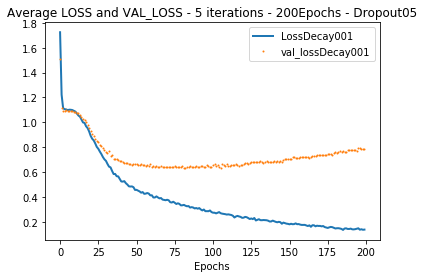

In [93]:
#######   MODIFY TXT FILE NAMES!!!!!!!!!!!!!!   ######

#Plot LOSS and val_loss - all decay
loss = {}
val_loss = {}
for k in range(1):
    loss[k] = np.zeros((PARAMETERS['n_iteration'], PARAMETERS['n_epoch'])) #MODIFY THE 20 TO BE WITH VARIABLE
    val_loss[k] = np.zeros((PARAMETERS['n_iteration'], PARAMETERS['n_epoch']))

loss_mean = np.zeros((1, PARAMETERS['n_epoch'] ))  #rows = n. of epochs; columns = n. of decay values
val_loss_mean = np.zeros((1, PARAMETERS['n_epoch'] ))


for k in range(1):   #scan along all the decay values
    for iteration in range(5): #scan along all the iterations
        loss[k][iteration,:] = np.loadtxt("/scratch/dwaithe/"+ str(filename)+ "LOSS_Iter_"+ str(iteration)+ "_DecVal_001" + ".txt")
        val_loss[k][iteration,:] = np.loadtxt("/scratch/dwaithe/"+ str(filename)+ "VAL_LOSS_Iter_"+ str(iteration)+ "_DecVal_001" + ".txt")
        
        #AVERAGE OF THE loss
        loss_mean[k,:] = np.mean(loss[k], axis = 0) 
        #AVERAGE OF THE VAL_Loss
        val_loss_mean[k,:] = np.mean(val_loss[k], axis = 0) 
         

#PLOT
fig, ax = plt.subplots()
for i in range(1):
    ax.plot(loss_mean[i,:],'-', linewidth=2, label = 'Loss'+'Decay001') #)+str(decay_val[i]))
    ax.plot(val_loss_mean[i,:],'o', ms=1, label = 'val_loss'+'Decay001') #+str(decay_val[i]))

ax.set_xlabel('Epochs')
ax.set_title('Average LOSS and VAL_LOSS - 5 iterations - 200Epochs - Dropout05')
legend = plt.legend(loc='upper right', shadow=False, prop={'size':10})
fig.savefig('/scratch/dwaithe/16_06_2017_800Training_Dropout05_Epochs200_20Batch_LOSS_and_VAL_Loss.png')

In [ ]:
"""fig, ax = plt.subplots()
ax.plot(RESULTS[4][0][0].history['acc'])
ax.plot(RESULTS[4][1][0].history['acc'])
ax.plot(RESULTS[4][2][0].history['acc'])

ax.set_xlabel('Epochs')
ax.set_title('Average LOSS and VAL_LOSS - 5 iterations - 200Epochs - Decay_0.001')
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
"""


In [ ]:
#cnn.save('/scratch/dwaithe/Model_CNN_Calcium_signaling_DecayValue_Noise1800data.h5')


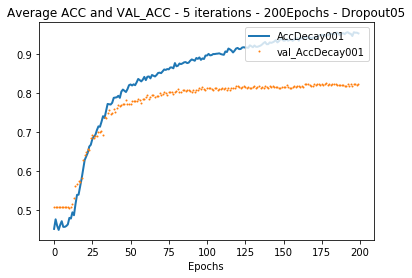

In [94]:
#######   MODIFY TXT FILE NAMES!!!!!!!!!!!!!!   ######

#Plot ACC and val_acc - all decay
acc = {}
val_acc = {}
for k in range(1):
    acc[k] = np.zeros((PARAMETERS['n_iteration'], PARAMETERS['n_epoch'])) #MODIFY THE 20 TO BE WITH VARIABLE
    val_acc[k] = np.zeros((PARAMETERS['n_iteration'], PARAMETERS['n_epoch']))

acc_mean = np.zeros((1, PARAMETERS['n_epoch'] ))  #rows = n. of epochs; columns = n. of decay values
val_acc_mean = np.zeros((1, PARAMETERS['n_epoch'] ))


for k in range(1):   #scan along all the decay values
    for iteration in range(5): #scan along all the iterations
        acc[k][iteration,:] = np.loadtxt("/scratch/dwaithe/"+ str(filename)+ "ACC_Iter_"+ str(iteration)+ "_DecVal_001" + ".txt")
        val_acc[k][iteration,:] = np.loadtxt("/scratch/dwaithe/"+ str(filename)+ "VAL_ACC_Iter_"+ str(iteration)+ "_DecVal_001" + ".txt")
        
        #AVERAGE OF THE ACC
        acc_mean[k,:] = np.mean(acc[k], axis = 0) 
        #AVERAGE OF THE VAL_ACC
        val_acc_mean[k,:] = np.mean(val_acc[k], axis = 0) 
         

#PLOT
fig, ax = plt.subplots()
for i in range(1):
    ax.plot(acc_mean[i,:],'-', linewidth=2, label = 'Acc'+'Decay001') #)+str(decay_val[i]))
    ax.plot(val_acc_mean[i,:],'o', ms=1, label = 'val_Acc'+'Decay001') #+str(decay_val[i]))

ax.set_xlabel('Epochs')
ax.set_title('Average ACC and VAL_ACC - 5 iterations - 200Epochs - Dropout05')
legend = plt.legend(loc='upper right', shadow=False, prop={'size':10})
fig.savefig('/scratch/dwaithe/16_06_2017_800Training_Dropout05_Epochs200_20Batch_ACC_and_VAL_ACC.png')

In [97]:
percentage = np.zeros(1*5)
k=0
for i in range(1):
    for iteration in range(5):
    #print('Iteration = ', iteration)
        #print('Decay value =', decay_val[i])
        percentage[k] = float(np.sum(np.argmax(RESULTS[iteration][i][1],1)==test_cl[iteration]))/float(test_cl[iteration].shape[0])*100.0
        #print('Prediction percentage', percentage)
        k=k+1
print(percentage)
np.savetxt("/scratch/dwaithe/16_06_2017_800Training_Dropout05_Epochs20_Prediction_percentage_NEW.txt", percentage,  fmt='%.4e', newline='\r\n')


[ 85.26315789  80.52631579  81.57894737  87.36842105  75.78947368]


In [ ]:
"""# Create plots with pre-defined labels.
fig, ax = plt.subplots()
for i in range(15,20):
    if test_cl[i] == 1:
        ax.plot(test_dt[i,:], label='Trig+Sing')
    if test_cl[i] == 2:
        ax.plot(test_dt[i,:], label='Trig+Osc')
    if test_cl[i] == 3:
        ax.plot(test_dt[i,:], label='Trig+Sust')
    if test_cl[i] == 4:
        ax.plot(test_dt[i,:], label='No-Trig')
    if test_cl[i] == 5:
        ax.plot(test_dt[i,:], label='Not Sure')
    legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')"""


In [ ]:
"""train_dt = to_export['training_data'] 
train_cl = to_export['train_cl']
test_dt = to_export['test_data']
test_cl = to_export['test_cl']
# import your data here instead
# X - inputs, 10000 samples of 128-dimensional vectors
# y - labels, 10000 samples of scalars from the set {0, 1, 2}

X = train_dt#np.random.rand(10000, 128).astype("float32")
y = train_cl #np.random.randint(3, size=(10000,1))

# process the data to fit in a keras CNN properly
# input data needs to be (N, C, X, Y) - shaped where
# N - number of samples
# C - number of channels per sample
# (X, Y) - sample size

X = X.reshape((10000, 128,1, 1))

# output labels should be one-hot vectors - ie,
# 0 -> [0, 0, 1]
# 1 -> [0, 1, 0]
# 2 -> [1, 0, 0]
# this operation changes the shape of y from (10000,1) to (10000, 3)

y = np_utils.to_categorical(y)

# define a CNN
# see http://keras.io for API reference

cnn = Sequential()
cnn.add(Convolution2D(64, 3, 1,border_mode="same",activation="relu",input_shape=(128,1, 1)))
cnn.add(Convolution2D(64, 3, 1, border_mode="same", activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,1)))

cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
cnn.add(Convolution2D(128, 3, 1, border_mode="same", activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,1)))
    
cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
cnn.add(Convolution2D(256, 3, 1, border_mode="same", activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,1)))
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(3, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01))

# train

cnn.fit(X, y, nb_epoch=20, verbose =2, show_accuracy=True)"""

In [ ]:
#Evaluation code which makes prediction
#out = cnn.predict(test_dt.reshape((10000, 128,1, 1)))


In [ ]:
#%pylab inline
#print out[0]
#print test_cl[0]

#print float(np.sum(np.argmax(out,1)==test_cl))/float(test_cl.shape[0])*100.0